# Rank Testing

Unpaired/Independent Test:
* Have $N_x$ samples from unknown distribution $\rho(x)$
* Have $N_y$ samples from unknown distribution $\rho(y)$
* Want to test  $ \langle x \rangle > \langle y \rangle$
* Thus need to estimate the p-value of the null hypothesis $p = P[Data | \langle x \rangle \leq \langle y \rangle]$

|Method|Distribution|Known Var|Uses Magnitude|Comments|
|--|--|--|--|--|
|[intependent t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test)| Normal | Yes | Yes | Best test for normal |
|[Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test)| Normal | Yes | No | Good approx for unknown var |
|[Mann-Whiteley U Test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)| Any | No | ??? | Allegedly 0.95% performance in asymptotic normality |
  
Paired Test:
* Have $N$ samples from unknown distribution $\rho(x, y)$
* Want to test  $\langle x-y \rangle > 0$
* Thus need to estimate the p-value of the null hypothesis $p = P[Data | \langle x-y \rangle \leq 0]$

|Method|Distribution|Known Var|Uses Magnitude|Comments|
|--|--|--|--|--|
|[paired Z-Test](https://en.wikipedia.org/wiki/Z-test)| Normal | Yes | Yes | Best test for normal|
|[paired t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#One-sample_t-test)| Normal | No | Yes | Best test for normal|
|[Binomial rank test](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)| Any | No | No | Very weak, do not use |
|[Wilcoxon's signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)| Any | No | Yes | Comparable to normal, very good |
  

In [1]:
import numpy as np
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon
from scipy.stats import binom
import matplotlib.pyplot as plt


from sklearn import linear_model
from scipy.special import expit, seterr

In [2]:
# Binary section search
# Find argument of a monotonic function in range [l,r], for which F(arg) ~ trg +/- acc
def binsect(func, l, r, trg, relAcc=0.01):
    fl = func(l)
    fr = func(r)
    fmid = fr
    if fl > fr:
        l,r = r,l
    
    while np.abs(fmid/trg - 1) > relAcc:
        mid = (l + r) / 2
        fmid = func(mid)
        if fmid < trg:
            l, fl = mid, fmid
        else:
            r, fr = mid, fmid
            
    return mid

# Calculate p-value for two shifted gaussians
def pval_generic(nSample, delta, testfunc):
    x = np.random.normal(0,1,nSample)
    y = np.random.normal(delta,1,nSample)
    return testfunc(x,y)

# Test p-value for two shifted gaussians
def test_generic(nSample, delta, testfunc):
    return pval_generic(nSample, delta, testfunc) < 0.01


'''
algorithm:
1. initialize parameter p
2. Construct binomial pval = P[n < nTrue | p] = F(p)
3. Solve p = Finv(pval) using binary section
'''
def bintest(x, y):
    n = len(x)
    nL = np.sum(x <= y)
    nR = np.sum(x >= y)
    
    cdfL = lambda p: binom.cdf(nL, n, p)
    cdfR = lambda p: binom.cdf(nR, n, p)
    
    pL = binsect(cdfL, 0, 1, 0.01)
    pR = binsect(cdfR, 0, 1, 0.01)
    return np.min([pL, pR])

    
testFuncDict = {
    't_test_paired'  : lambda x,y : ttest_rel(x,y)[1],
    't_test_welch'   : lambda x,y : ttest_ind(x,y, equal_var=False)[1],
    'mannwhitneyu'   : lambda x,y : mannwhitneyu(x,y)[1],
    'signedrank'     : lambda x,y : wilcoxon(x,y)[1],
    'binomial'       : lambda x,y : bintest(x,y)
}

In [3]:
# Adaprively sample a binary function to improve fitness of logistic curve
def adaptive_logistic_sampling(testfunc):
    one_test = lambda n : (n, testfunc(n))
    rezLst = []
        
    # Step 1: Find n for which 10/10 tests are true
    N_RESAMPLE = 20
    n = 2
    l = 2
    done = False
    while not done:
        tmpLst = [one_test(n) for i in range(N_RESAMPLE)]
        rezLst += tmpLst
        testRez = np.array([tmpLst[i][1] for i in range(N_RESAMPLE)])
        done = np.all(testRez)
        if np.all(~testRez):
            l = n
        n *= 2

    # Step 2: Randomly sample the interval in which probability is somewhere between [0,1]
    r = rezLst[-1][0]
    for i in range(200):
        rezLst += [one_test(np.random.randint(l, r + 1))]
        
    return np.array(rezLst).T


# Fit logistic curve to data, can also plot the fit
def fit_log_reg(x, y, plot=True):
    # Fit the classifier
    clf = linear_model.LogisticRegression(solver='lbfgs')
    xfancy = np.copy(x)
    xfancy = xfancy[:, np.newaxis]

    clf.fit(xfancy, y)

    if plot:    
        plt.figure()
        plt.scatter(x, r)
        x_test = np.linspace(np.min(x), np.max(x), 1000)
        loss = expit(x_test * clf.coef_ + clf.intercept_)[0]
        plt.plot(x_test, loss, color='red', linewidth=3)
    
    return clf

# Inverse of a logistic curve
def invert_log_reg(clf, p):
    x = np.log(p / (1-p))
    xSh = (x - clf.intercept_) / clf.coef_
    return xSh[0][0]

For each test, compute p-value at fixed number of samples, as function of distance between gaussians

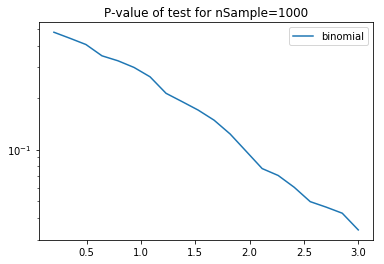

In [4]:
numDelta = 20
nSample = 1000
deltaArr = np.flip(np.linspace(0.2, 3, numDelta))

plt.figure()
for testName, testFunc in testFuncDict.items():
    if testName == 'binomial':
        pValArr = np.zeros(numDelta)
        for i, delta in enumerate(deltaArr):
            pValArr[i] = pval_generic(nSample, delta, testFunc)

        plt.semilogy(deltaArr, pValArr, label=testName)

plt.legend()
plt.title("P-value of test for nSample="+str(nSample))
plt.show()

For each test, find number of samples necessary to reach a given confidence, as function of distance between gaussians

/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/scipy/stats/

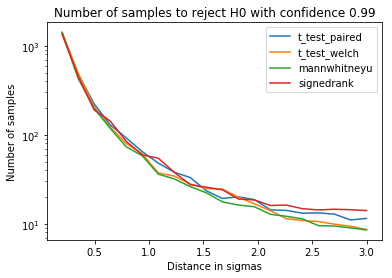

In [5]:
P_THR = 0.99
numDelta = 20
deltaArr = np.flip(np.linspace(0.2, 3, numDelta))

plt.figure()
for testName, testFunc in testFuncDict.items():
    if testName != 'binomial':
        nSampleFit = np.zeros(numDelta)
        for i, delta in enumerate(deltaArr):
            #print(testName, delta)
            test_wrapper = lambda n : test_generic(n, delta, testFunc)
            s, r = adaptive_logistic_sampling(test_wrapper)
            clf = fit_log_reg(np.sqrt(s), r, plot=False)
            sQuant = invert_log_reg(clf, P_THR)
            nSampleFit[i] += sQuant**2

        plt.semilogy(deltaArr, nSampleFit, label=testName)
    
plt.legend()
plt.title("Number of samples to reject H0 with confidence " + str(P_THR))
plt.ylabel("Number of samples")
plt.xlabel("Distance in sigmas")
plt.show()

In [6]:
x = np.random.normal(0,1,100)
y = np.random.normal(1,1,100)

print(wilcoxon(x,y))
print(bintest(x,y))

WilcoxonResult(statistic=824.0, pvalue=4.957557153988046e-09)
0.3427734375


0.81884765625 0.00994486443051774


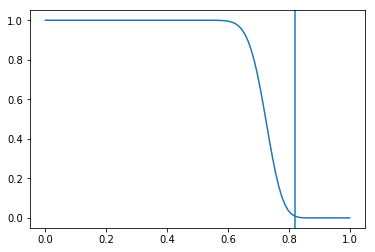

In [7]:
pos = np.linspace(0,1,100)
aaa = [binom.cdf(72, 100, p) for p in pos]
bs = binsect(lambda p: binom.cdf(72, 100, p), 0, 1, 0.01)

print(bs, binom.cdf(72, 100, bs))

plt.figure()
plt.plot(pos, aaa)
plt.axvline(x=bs)
plt.show()